In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Configuration for overlay positions (x, y, width, height)
OVERLAY_POSITIONS = {
    'cap': (128, 2, 182, 60),  # Default cap position
    'texas_cap': (140, 2, 182, 60),
    'aus_cap': (140, 2, 182, 60),
}

def load_image(image_path):
    """Load image in RGB format"""
    try:
        image = Image.open(image_path).convert('RGB')
        return np.array(image)
    except Exception as e:
        raise ValueError(f"Error loading image {image_path}: {e}")

def load_and_prepare_overlay(overlay_path, target_width, target_height):
    """Load overlay and resize/pad to match target dimensions"""
    image = cv2.imread(overlay_path, cv2.IMREAD_UNCHANGED)
    
    if image is None:
        raise ValueError(f"Failed to load overlay image: {overlay_path}")
    
    height, width = image.shape[:2]
    
    # If overlay is larger than target, resize it down while preserving aspect ratio
    if height > target_height or width > target_width:
        scale = min(target_width / width, target_height / height)
        new_width = int(width * scale)
        new_height = int(height * scale)
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        height, width = new_height, new_width
    
    # Calculate padding (now guaranteed to be positive)
    pad_top = (target_height - height) // 2
    pad_bottom = target_height - height - pad_top
    pad_left = (target_width - width) // 2
    pad_right = target_width - width - pad_left
    
    # Pad with transparent pixels
    padded_image = cv2.copyMakeBorder(
        image, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=[0, 0, 0, 0]
    )
    
    # Convert BGR(A) to RGB(A) to match load_image format
    if padded_image.shape[2] == 4:
        padded_image = cv2.cvtColor(padded_image, cv2.COLOR_BGRA2RGBA)
    else:
        padded_image = cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB)
    
    return padded_image

def overlay_image(source, overlay, bbox):
    """Overlay image with alpha blending at specified bounding box"""
    x, y, w, h = bbox
    
    # Validate bbox is within source bounds
    if y + h > source.shape[0] or x + w > source.shape[1]:
        raise ValueError(f"Bounding box {bbox} exceeds source image dimensions {source.shape[:2]}")
    
    resized_overlay = cv2.resize(overlay, (w, h))
    
    # Create mask from alpha channel
    if resized_overlay.shape[2] == 4:
        mask = resized_overlay[:, :, 3:4] / 255.0  # Keep as 3D array
        resized_overlay = resized_overlay[:, :, :3]  # Remove alpha from overlay
    else:
        mask = np.ones((h, w, 1))
    
    # Ensure source is 3-channel (remove alpha if present)
    if source.shape[2] == 4:
        source = source[:, :, :3]
    
    # Extract ROI and blend
    roi = source[y:y+h, x:x+w].astype(float)
    blended = roi * (1 - mask) + resized_overlay.astype(float) * mask
    
    result = source.copy()
    result[y:y+h, x:x+w] = blended.astype(np.uint8)
    
    return result

def create_meme_variant(source_path, overlay_path, bbox=None, position_preset=None):
    """
    Create meme variant with automatic overlay positioning
    
    Args:
        source_path: Path to source image
        overlay_path: Path to overlay element
        bbox: (x, y, w, h) or None for automatic positioning
        position_preset: Key from OVERLAY_POSITIONS dict
    """
    source = load_image(source_path)
    overlay = load_and_prepare_overlay(overlay_path, source.shape[1], source.shape[0])
    
    if bbox is None:
        if position_preset and position_preset in OVERLAY_POSITIONS:
            bbox = OVERLAY_POSITIONS[position_preset]
        else:
            # Default: use entire overlay dimensions at top-center
            overlay_h, overlay_w = overlay.shape[:2]
            x = (source.shape[1] - overlay_w) // 2
            y = 0
            bbox = (x, y, overlay_w, overlay_h)
    
    return overlay_image(source, overlay, bbox)

def display_image(image):
    plt.figure(figsize=(10,8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def calc_dim_resize(image, target_height, target_width):
    resized_image = cv2.resize(image, (target_width, target_height))
    return resized_image

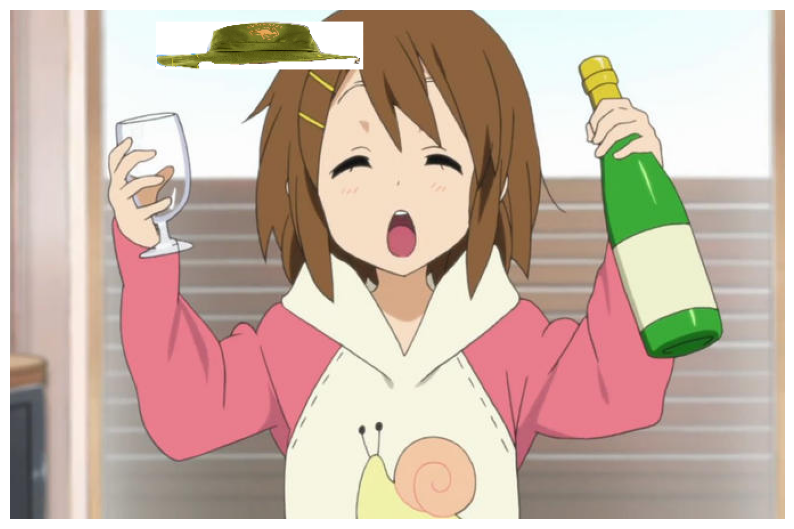

In [4]:
# Example 1: Using the convenient create_meme_variant function with preset position
image_path = 'images/source_pic.jpg'
overlay_path = 'images/aus_cap.png'

result = create_meme_variant(image_path, overlay_path, position_preset='aus_cap')
display_image(result)

In [ ]:
# Example 2: Manual control with custom bounding box
image_path = 'images/source_pic.jpg'
overlay_path = 'images/aus_cap.png'

source = load_image(image_path)
overlay = load_and_prepare_overlay(overlay_path, source.shape[1], source.shape[0])

print("source shape:", source.shape)
print("overlay shape:", overlay.shape)

# Custom bounding box: (x, y, width, height)
bbox = (128, 2, 182, 60)

result = overlay_image(source, overlay, bbox)
display_image(result)